In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# apply some styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

In [31]:
weather_df = pd.read_csv('cleaned_weather.csv')
# read the solar plant generation data
solar_df = pd.read_csv('plant_output.csv')
# drop unused columns
solar_df = solar_df.drop(['Plant', 'Real-time power(kW)', 'Daily feed-in energy(kWh)', 'Energy purchased today(kWh)'], axis=1)

# Both weather and solar df are date aligned
data_df = weather_df
data_df['output'] = solar_df['Daily yield(kWh)']
# Remove entries with known 0 output
data_df = data_df[~(data_df['output'] == 0)]
data_df.drop(data_df.columns[0], axis=1, inplace=True)

/var/folders/zh/nt4cvtjd1bl_ntm3_d6kztf40000gn/T/ipykernel_41202/720678684.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.drop(data_df.columns[0], axis=1, inplace=True)


In [32]:
data_df.head()

,datetime,tempmax,tempmin,temp,dew,humidity,precip,precipprob,precipcover,cloudcover,solarradiation,solarenergy,solartime,output
0,2025-01-01,29.0,16.1,22.0,15.8,70.6,0.0,0,0.0,3.2,212.9,18.5,662.33,11.7
1,2025-01-02,30.8,14.9,22.1,13.6,63.1,0.0,0,0.0,8.9,218.2,18.8,662.62,12.5
2,2025-01-03,29.3,12.9,21.0,10.4,56.5,0.0,0,0.0,30.0,222.0,19.2,662.92,12.7
3,2025-01-04,29.8,11.2,20.0,8.6,51.8,0.0,0,0.0,3.9,224.0,19.4,663.23,10.5
4,2025-01-05,30.1,12.2,20.7,10.2,54.5,0.0,0,0.0,20.6,217.9,18.9,663.58,11.1


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
scaler = StandardScaler()
numeric_cols = data_df.select_dtypes(include=[np.number]).columns
data_df = data_df[numeric_cols]
data_norm = pd.DataFrame(scaler.fit_transform(data_df), columns=data_df.columns)
data_norm.head(5)

,tempmax,tempmin,temp,dew,humidity,precip,precipprob,precipcover,cloudcover,solarradiation,solarenergy,solartime,output
0,-1.403946,-0.829721,-1.376138,0.242118,1.004365,-0.293308,-0.6003,-0.451987,-0.883851,-0.680943,-0.651917,-1.509529,-0.281256
1,-0.916350,-1.188969,-1.340224,-0.316047,0.483319,-0.293308,-0.6003,-0.451987,-0.686336,-0.583275,-0.588037,-1.502480,-0.042159
2,-1.322680,-1.787716,-1.735276,-1.127923,0.024799,-0.293308,-0.6003,-0.451987,0.044818,-0.513248,-0.502863,-1.495189,0.017616
3,-1.187236,-2.296651,-2.094413,-1.584603,-0.301724,-0.293308,-0.6003,-0.451987,-0.859595,-0.476393,-0.460277,-1.487654,-0.639903
4,-1.105970,-1.997277,-1.843017,-1.178665,-0.114147,-0.293308,-0.6003,-0.451987,-0.280909,-0.588803,-0.566744,-1.479148,-0.460580


In [34]:
# Split data 
X = data_norm.drop('output', axis=1)
y = data_norm['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
print( 'X ', X.shape)
print( 'y ', y.shape)
print( 'X_train ', X_train.shape)
print( 'y_train ', y_train.shape)

X  (151, 12)
y  (151,)
X_train  (120, 12)
y_train  (120,)


In [35]:
from ParamTester import ParamTester
from ParamTester import predict_and_eval

In [36]:
dt_reg = DecisionTreeRegressor(random_state=0)
dt_reg.fit(X_train, y_train)

dt_metrics, dt_y_train_pred, dt_y_test_pred = predict_and_eval(dt_reg, X_train, y_train, X_test, y_test)

Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 1.2653249371266673
Test R-squared: -0.86717736294183


In [37]:
# Tree details
print ('depth: ', dt_reg.get_depth())
print ('leaves: ',dt_reg.get_n_leaves())
print ('features: ',dt_reg.max_features_)

depth:  12
leaves:  113
features:  12


In [38]:
# It seems the the curren tree model have high bias(underfitting). Let's try adding more features using PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly  = poly.fit_transform(X)
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [39]:
dt_poly_reg = DecisionTreeRegressor(random_state=0)
dt_poly_reg.fit(X_poly_train, y_poly_train)

dt_poly_metrics, dt_poly_y_train_pred, dt_poly_y_test_pred = predict_and_eval(dt_poly_reg, X_poly_train, y_poly_train, X_poly_test, y_poly_test)

Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.6484959587132004
Test R-squared: 0.4247738871620673


In [40]:
# Tree details
print ('depth: ', dt_poly_reg.get_depth())
print ('leaves: ',dt_poly_reg.get_n_leaves())
print ('features: ',dt_poly_reg.max_features_)

depth:  11
leaves:  104
features:  90


### Observations
1. Polynomial features significantly improved the R2 score 
2. At the same time, the training R2 score of 1 indicates overfitting

To address this following variations with max_features, max_leaf nodes are performed.

In [41]:
param_info = [
    {
        'name': 'max_features',
        'type': 'int',
        'params': {'random_state' : 0},
        'values': [20, 40, 60, 80, 100, 120]
    },
    {        
        'name': 'max_leaf_nodes',
        'type': 'int',
        'params': {'random_state' : 0},
        'values': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    },
    {        
        'name': 'max_depth',
        'type': 'int',
        'params': {'random_state' : 0},
        'values': [4, 8, 12, 16, 20, 24, 28, 32]
    },
    {
        'name': 'min_samples_leaf',
        'type': 'int',
        'params': {'random_state' : 0},
        'values': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    },
    {
        'name': 'min_samples_split',
        'type': 'int',
        'params': {'random_state' : 0},
        'values': [2, 5, 10, 15, 20]
    }
]
pt = ParamTester(DecisionTreeRegressor, X_poly_train, y_poly_train, X_poly_test, y_poly_test)
pt.init_test_params(param_info)
pt.get_attr('param_info')

Parameter information:
Parameter: max_features, Values: [20, 40, 60, 80, 100, 120], Params: {'random_state': 0}
Parameter: max_leaf_nodes, Values: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50], Params: {'random_state': 0}
Parameter: max_depth, Values: [4, 8, 12, 16, 20, 24, 28, 32], Params: {'random_state': 0}
Parameter: min_samples_leaf, Values: [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], Params: {'random_state': 0}
Parameter: min_samples_split, Values: [2, 5, 10, 15, 20], Params: {'random_state': 0}


--- Running tests for parameter: max_features ---
Updated params: {'random_state': 0}
-- Testing max_features with value: 20 with {'random_state': 0, 'max_features': 20}
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 1.4804817541404178
Test R-squared: -0.31321059617937363
-- Testing max_features with value: 40 with {'random_state': 0, 'max_features': 40}
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.6340599649641862
Test R-squared: 0.4375788406203366
-- Testing max_features with value: 60 with {'random_state': 0, 'max_features': 60}
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.5888214216788523
Test R-squared: 0.4777061398807805
-- Testing max_features with value: 80 with {'random_state': 0, 'max_features': 80}
Train Mean Squared Error: 0.0
Train R-squared: 1.0
Test Mean Squared Error: 0.6101440471763984
Test R-squared: 0.4587926357707621
-- Testing max_features with value: 100 with {'random_st

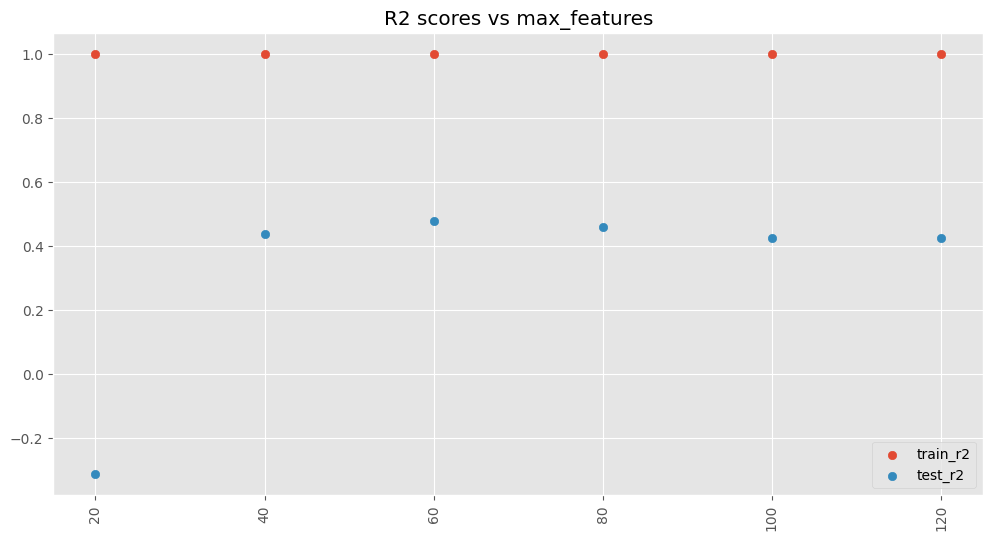

--- Running tests for parameter: max_leaf_nodes ---
Updated params: {'random_state': 0, 'max_features': 60}
-- Testing max_leaf_nodes with value: 5 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 5}
Train Mean Squared Error: 0.3067269866232405
Train R-squared: 0.6808619453734743
Test Mean Squared Error: 0.47468411974210906
Test R-squared: 0.57894772148317
-- Testing max_leaf_nodes with value: 10 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10}
Train Mean Squared Error: 0.13046175841177282
Train R-squared: 0.8642593785403352
Test Mean Squared Error: 0.45931028364719767
Test R-squared: 0.5925845558496189
-- Testing max_leaf_nodes with value: 15 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 15}
Train Mean Squared Error: 0.07447361269484849
Train R-squared: 0.9225129678412117
Test Mean Squared Error: 0.5531640475791546
Test R-squared: 0.5093347914117428
-- Testing max_leaf_nodes with value: 20 with {'random_state': 0, 'max_features': 60, 'm

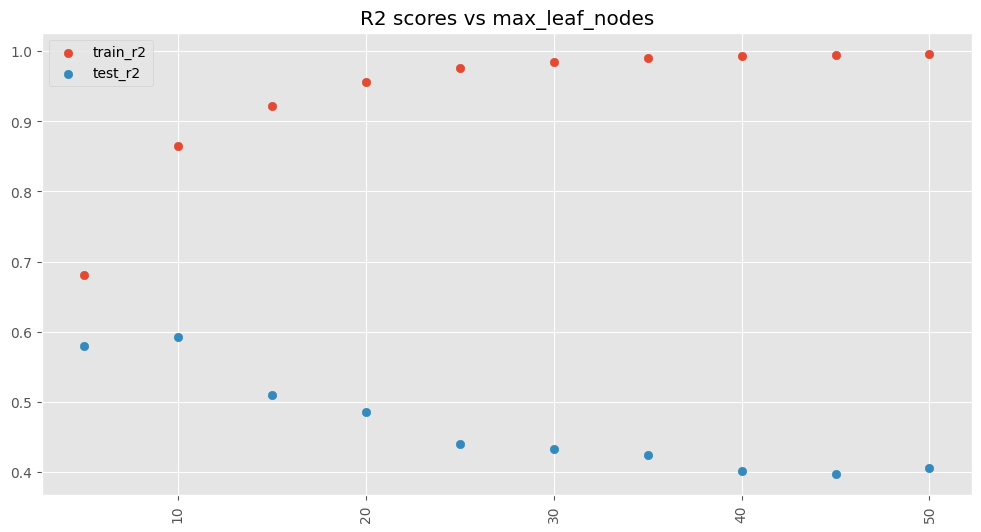

--- Running tests for parameter: max_depth ---
Updated params: {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10}
-- Testing max_depth with value: 4 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10, 'max_depth': 4}
Train Mean Squared Error: 0.19923535067061773
Train R-squared: 0.7927030062602359
Test Mean Squared Error: 0.7044576736005124
Test R-squared: 0.3751349660711041
-- Testing max_depth with value: 8 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10, 'max_depth': 8}
Train Mean Squared Error: 0.13046175841177282
Train R-squared: 0.8642593785403352
Test Mean Squared Error: 0.45931028364719767
Test R-squared: 0.5925845558496189
-- Testing max_depth with value: 12 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10, 'max_depth': 12}
Train Mean Squared Error: 0.13046175841177282
Train R-squared: 0.8642593785403352
Test Mean Squared Error: 0.45931028364719767
Test R-squared: 0.5925845558496189
-- Testing max_depth with value: 1

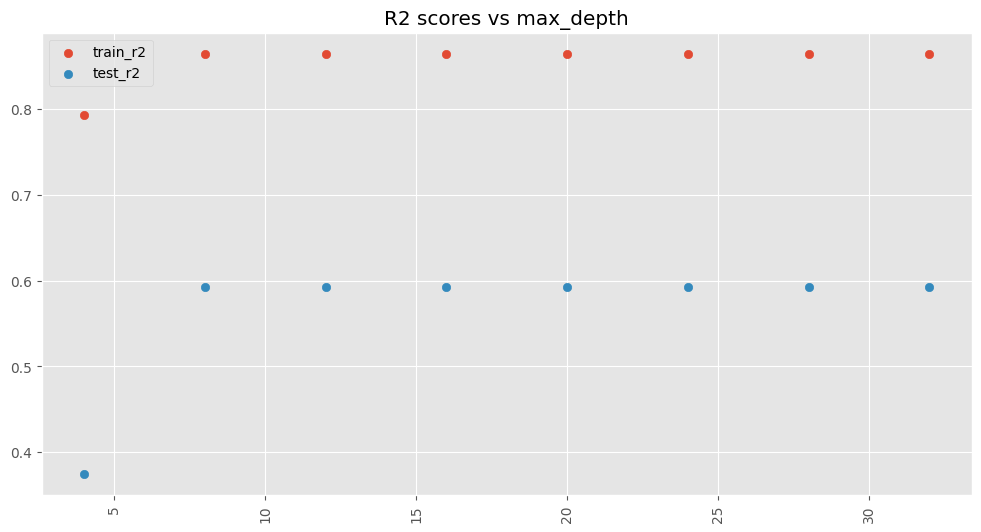

--- Running tests for parameter: min_samples_leaf ---
Updated params: {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10, 'max_depth': 8}
-- Testing min_samples_leaf with value: 1 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10, 'max_depth': 8, 'min_samples_leaf': 1}
Train Mean Squared Error: 0.13046175841177282
Train R-squared: 0.8642593785403352
Test Mean Squared Error: 0.45931028364719767
Test R-squared: 0.5925845558496189
-- Testing min_samples_leaf with value: 2 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10, 'max_depth': 8, 'min_samples_leaf': 2}
Train Mean Squared Error: 0.14412092371805604
Train R-squared: 0.8500475235886097
Test Mean Squared Error: 1.0391502136662585
Test R-squared: 0.07825742006465708
-- Testing min_samples_leaf with value: 4 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10, 'max_depth': 8, 'min_samples_leaf': 4}
Train Mean Squared Error: 0.16828551682684517
Train R-squared: 0.8249051606016413
Te

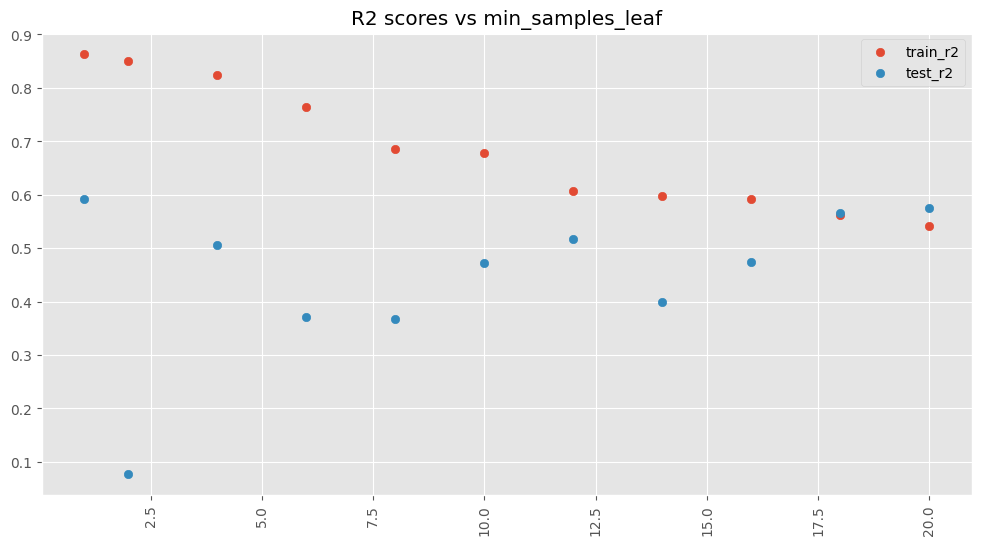

--- Running tests for parameter: min_samples_split ---
Updated params: {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10, 'max_depth': 8, 'min_samples_leaf': 1}
-- Testing min_samples_split with value: 2 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
Train Mean Squared Error: 0.13046175841177282
Train R-squared: 0.8642593785403352
Test Mean Squared Error: 0.45931028364719767
Test R-squared: 0.5925845558496189
-- Testing min_samples_split with value: 5 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5}
Train Mean Squared Error: 0.1304617584117728
Train R-squared: 0.8642593785403353
Test Mean Squared Error: 0.45931028364719767
Test R-squared: 0.5925845558496189
-- Testing min_samples_split with value: 10 with {'random_state': 0, 'max_features': 60, 'max_leaf_nodes': 10, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samp

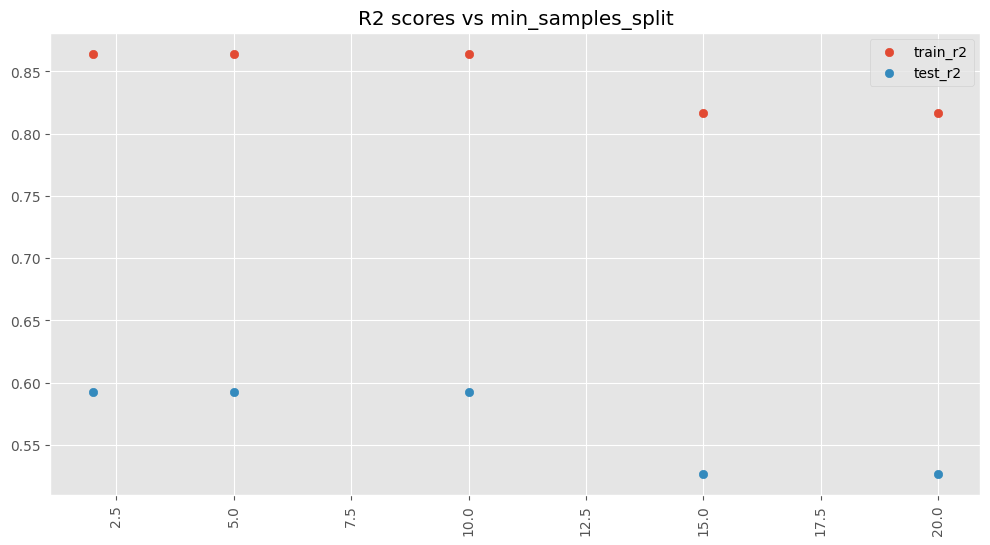

Current best parameters:
max_features: 60
max_leaf_nodes: 10
max_depth: 8
min_samples_leaf: 1
min_samples_split: 2


In [42]:
pt.run_param_tests()
pt.get_attr('best_params')

- In all variations training R2 score is close to 0.9 which indicates overfitting
- The test R2 score however peaks around 0.47 (`max_features` = 60) before delicing with increasing number of features
- The test R2 score however peaks around 0.59 (`max_depth` = 8) and stagnates with increasing number of max_depth
- The model with `max_leaf_nodes` = 10 could be more generalized as it shows training R2 = 0.86 and testing R2 = 0.6. The test R2 score however peaks at 0.6 (max_leaf_nodes = 10) and declines gradually towards 0.5
- Any `min_samples_leaf` count > 1 shows reduced R2 score for both training and test data. Hence changing the default value of 1 doesn't improve the accuracy.

In [43]:
# A final DT regressor test with optimal hyper parameters
dt_poly_reg_ = DecisionTreeRegressor(random_state=0, max_features=60, max_depth=8, max_leaf_nodes=10, min_samples_split=2, min_samples_leaf=1)
dt_poly_reg_.fit(X_poly_train, y_poly_train)

dt_poly_metrics_, dt_poly_y_train_pred, dt_poly_y_test_pred = predict_and_eval(dt_poly_reg_, X_poly_train, y_poly_train, X_poly_test, y_poly_test)

Train Mean Squared Error: 0.13046175841177282
Train R-squared: 0.8642593785403352
Test Mean Squared Error: 0.45931028364719767
Test R-squared: 0.5925845558496189


In [44]:
# Tree details
print ('depth: ', dt_poly_reg_.get_depth())
print ('leaves: ',dt_poly_reg_.get_n_leaves())
print ('features: ',dt_poly_reg_.max_features_)

depth:  6
leaves:  10
features:  60
